# NBA Player Position Classification

**CPSC 322 - Data Science Algorithms**  
**Fall 2025**  
**Student:** Jacob Jarvis and Andrew Morton

---

## 1. Introduction

This project implements a system to classify NBA players into their positions (Point Guard, Shooting Guard, Small Forward, Power Forward, and Center) based on their statistical performance across **three consecutive NBA seasons: 2021-2022, 2022-2023, and 2023-2024**. The classification task is particularly interesting in the modern NBA era, where traditional position boundaries have become increasingly blurred due to the evolution toward "position-less basketball."

### Datasets

The datasets contain comprehensive statistics for NBA players from three consecutive regular seasons, sourced from Basketball-Reference.com via Kaggle. After preprocessing to handle traded players and filter out those with insufficient playing time (< 10 games or < 10 minutes per game), the combined dataset provides:

- **~1200+ player instances** across three seasons
- **12 features** including points, rebounds, assists, steals, blocks, shooting percentages, and derived metrics
- **5 classes** representing the five traditional basketball positions: PG, SG, SF, PF, C

### Multi-Season Analysis

This expanded analysis includes:
1. **Per-season analysis** - Examining how position characteristics evolved from 2021-2024
2. **Combined dataset training** - Using all three seasons for improved model accuracy
3. **Cross-season validation** - Testing models trained on one season against other seasons
4. **Temporal trends** - Tracking how position definitions change over time

### Classification Task

The goal is to predict a player's position based solely on their statistical profile. This task tests whether traditional position designations can be reliably inferred from playing statistics, or whether the modern game has truly evolved beyond these categories.

---

In [1]:
# Import required libraries
import sys
import os

# Add current directory to path for mysklearn package
current_dir = os.path.dirname(os.path.abspath('__file__'))
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from mysklearn.myclassifiers import (MyDecisionTreeClassifier, MyKNeighborsClassifier, 
                                     MyNaiveBayesClassifier, MyDummyClassifier)
from mysklearn.myevaluation import (train_test_split, stratified_kfold_split, bootstrap_sample,
                                    confusion_matrix, accuracy_score)
from mysklearn.myrandomforest import MyRandomForestClassifier

import importlib
import nba_preprocessing
importlib.reload(nba_preprocessing)
from nba_preprocessing import preprocess_nba_data

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

---

## 2. Data Analysis

### 2.1 Multi-Season Dataset Description

The NBA Player Statistics datasets were obtained from Kaggle and originally scraped from Basketball-Reference.com. The data includes both traditional counting statistics and advanced metrics for all players who appeared in games during three consecutive NBA regular seasons: **2021-2022, 2022-2023, and 2023-2024**.

#### Preprocessing Steps (Applied to Each Season)

1. **Handling Traded Players:** Kept only "TOT" (total) row for each traded player
2. **Position Simplification:** Extracted primary position from hybrid designations (e.g., "PG-SG" → "PG")
3. **Filtering Low Playing Time:** Removed players with < 10 games or < 10 minutes per game
4. **Feature Engineering:** Created derived features (3P_rate, ORB_rate, AST/TO ratio)

---

In [ ]:
# Load and combine data from all three seasons
print("Multi-Season NBA Data Loading\n")

seasons = {
    '2021-2022': '2021-2022 NBA Player Stats - Regular.csv',
    '2022-2023': '2022-2023 NBA Player Stats - Regular.csv',
    '2023-2024': '2023-2024 NBA Player Stats - Regular.csv'
}

# Load each season
all_X = []
all_y = []
season_labels = []
season_dfs = []

for season_name, filepath in seasons.items():
    print(f"Processing {season_name} Season...")
    
    X_np, y_np, feature_names, df = preprocess_nba_data(filepath, discretize=True, n_bins=10)
    
    # Add to combined lists
    all_X.extend(X_np.tolist())
    all_y.extend(y_np.tolist())
    season_labels.extend([season_name] * len(X_np))
    
    # Store dataframe with season label
    df['Season'] = season_name
    season_dfs.append(df)
    
    print(f"  Loaded {len(X_np)} players from {season_name}\n")

# Create the main combined dataset
X = all_X
y = all_y
X_np = np.array(X)
y_np = np.array(y)
df = pd.concat(season_dfs, ignore_index=True)

print("\nCombined Dataset Summary")
print(f"Total Instances: {len(X)}")
print(f"Total Features: {len(feature_names)}")
print(f"Seasons: 2021-2022, 2022-2023, 2023-2024")
print(f"Feature Names: {feature_names}\n")

print("Class Distribution:")
for pos, count in sorted(Counter(y).items()):
    print(f"  {pos}: {count} players ({count/len(y)*100:.1f}%)")

print(f"\nDataset shape: {df.shape}")
print("Data loading complete - using combined three-season dataset for all analyses\n")

MULTI-SEASON NBA DATA LOADING

Processing 2021-2022 Season...
NBA DATA PREPROCESSING

1. Loading data...
Loaded 812 rows

2. Handling traded players...
Original rows: 812
After handling trades: 605
Traded players (with TOT stats): 97

3. Simplifying positions...

Position distribution after simplification:
Pos
SG    156
SF    122
PG    114
PF    110
C     103
Name: count, dtype: int64

4. Filtering low playtime players...

Filtered players with < 10 games or < 10.0 MPG
Removed: 167 players
Remaining: 438 players

5. Creating derived features...

6. Selecting features for classification...

Discretizing features into 10 bins...

Features selected: 12
Feature names: ['PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P', '3P%', '3P_rate', 'FT%', 'TOV', 'MP']
Discretized: True
Class distribution:
Pos
SG    99
SF    87
PG    87
PF    87
C     78
Name: count, dtype: int64

PREPROCESSING COMPLETE
Final dataset: 438 instances, 12 features
  Loaded 438 players from 2021-2022

Processing 2022-2023 Sea

### 2.2 Cross-Season Comparison

In [ ]:
# Compare key statistics across seasons
print("Cross-Season Statistical Comparison\n")

key_stats = ['PTS', 'TRB', 'AST', '3P', 'FG%', 'MP']

for stat in key_stats:
    print(f"\n{stat} by Position and Season:")
    
    comparison = df.pivot_table(
        values=stat,
        index='Pos',
        columns='Season',
        aggfunc='mean'
    ).round(2)
    
    print(comparison)
    
    # Calculate change from 2021-2022 to 2023-2024
    if '2021-2022' in comparison.columns and '2023-2024' in comparison.columns:
        change = (comparison['2023-2024'] - comparison['2021-2022']).round(2)
        print(f"\nChange from 2021-2022 to 2023-2024:")
        for pos in comparison.index:
            print(f"  {pos}: {change[pos]:+.2f}")

print("\n\nKey Observations:")
print("- Track how each position's statistical profile has evolved over three seasons")
print("- Identify trends in scoring, assists, rebounding, and shooting across the league")

CROSS-SEASON STATISTICAL COMPARISON


PTS by Position and Season:
Season  2021-2022  2022-2023  2023-2024
Pos                                    
C           10.03       9.91       9.88
PF           9.95      10.30      10.89
PG          11.38      12.22      11.63
SF           9.87      10.62       9.65
SG          10.39      11.03      10.43

Change from 2021-2022 to 2023-2024:
  C: -0.15
  PF: +0.94
  PG: +0.25
  SF: -0.22
  SG: +0.04

TRB by Position and Season:
Season  2021-2022  2022-2023  2023-2024
Pos                                    
C            6.67       6.40       6.45
PF           4.77       4.69       4.66
PG           3.15       3.19       3.02
SF           3.61       3.73       3.62
SG           3.06       2.91       2.90

Change from 2021-2022 to 2023-2024:
  C: -0.22
  PF: -0.11
  PG: -0.13
  SF: +0.01
  SG: -0.16

AST by Position and Season:
Season  2021-2022  2022-2023  2023-2024
Pos                                    
C            1.58       1.61       1.80
PF  

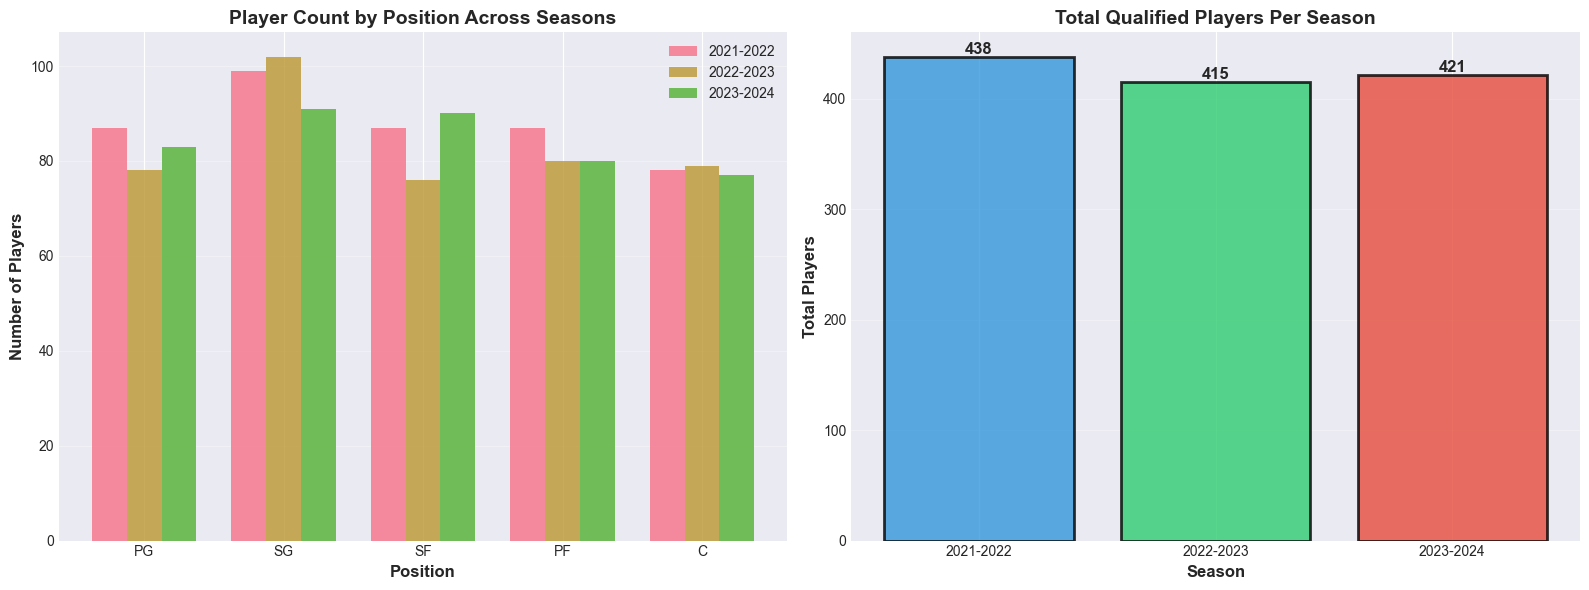


Figure: Distribution of positions across three NBA seasons shows relative stability
in position representation, with slight variations in total qualified players per season.


In [4]:
# Visualize position distribution across seasons
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Position counts by season (grouped bar chart)
ax1 = axes[0]
positions = ['PG', 'SG', 'SF', 'PF', 'C']
season_names = ['2021-2022', '2022-2023', '2023-2024']
x = np.arange(len(positions))
width = 0.25

for i, season in enumerate(season_names):
    season_df = df[df['Season'] == season]
    counts = [len(season_df[season_df['Pos'] == pos]) for pos in positions]
    ax1.bar(x + i*width, counts, width, label=season, alpha=0.8)

ax1.set_xlabel('Position', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Players', fontsize=12, fontweight='bold')
ax1.set_title('Player Count by Position Across Seasons', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width)
ax1.set_xticklabels(positions)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Total players per season
ax2 = axes[1]
season_totals = [len(df[df['Season'] == season]) for season in season_names]
colors_seasons = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax2.bar(season_names, season_totals, color=colors_seasons, alpha=0.8, edgecolor='black', linewidth=2)

ax2.set_xlabel('Season', fontsize=12, fontweight='bold')
ax2.set_ylabel('Total Players', fontsize=12, fontweight='bold')
ax2.set_title('Total Qualified Players Per Season', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print("\nFigure: Distribution of positions across three NBA seasons shows relative stability")
print("in position representation, with slight variations in total qualified players per season.")

### 2.2 Summary Statistics by Position

In [5]:
# Generate summary statistics by position
key_stats = ['PTS', 'TRB', 'AST', 'STL', 'BLK', '3P', 'FG%', 'MP']
summary_stats = df.groupby('Pos')[key_stats].agg(['mean', 'std']).round(2)

print("\nSummary Statistics by Position:")
print(summary_stats)

print("\n\nKey Observations:")
print("- Centers (C) have highest rebounds (avg:", df[df['Pos']=='C']['TRB'].mean().round(2), 
      ") and blocks (avg:", df[df['Pos']=='C']['BLK'].mean().round(2), ")")
print("- Point Guards (PG) lead in assists (avg:", df[df['Pos']=='PG']['AST'].mean().round(2), ")")
print("- Guards/Wings shoot more 3-pointers than big men")


Summary Statistics by Position:
       PTS         TRB         AST         STL         BLK          3P        \
      mean   std  mean   std  mean   std  mean   std  mean   std  mean   std   
Pos                                                                            
C     9.94  6.06  6.51  2.88  1.66  1.46  0.57  0.30  0.92  0.57  0.45  0.58   
PF   10.37  6.66  4.71  2.07  1.86  1.51  0.64  0.31  0.53  0.35  1.05  0.72   
PG   11.73  7.45  3.12  1.58  4.28  2.35  0.89  0.40  0.28  0.20  1.42  0.97   
SF   10.02  5.98  3.65  1.55  1.83  1.24  0.71  0.34  0.36  0.22  1.28  0.77   
SG   10.63  6.06  2.96  1.29  2.36  1.53  0.72  0.35  0.28  0.19  1.52  0.86   

      FG%           MP        
     mean   std   mean   std  
Pos                           
C    0.57  0.09  21.40  7.45  
PF   0.47  0.07  22.55  7.92  
PG   0.43  0.05  24.09  8.14  
SF   0.45  0.05  22.85  7.72  
SG   0.44  0.05  22.89  7.64  


Key Observations:
- Centers (C) have highest rebounds (avg: 6.51 ) and block

### 2.3 Data Visualizations

#### Figure 1: Class Distribution

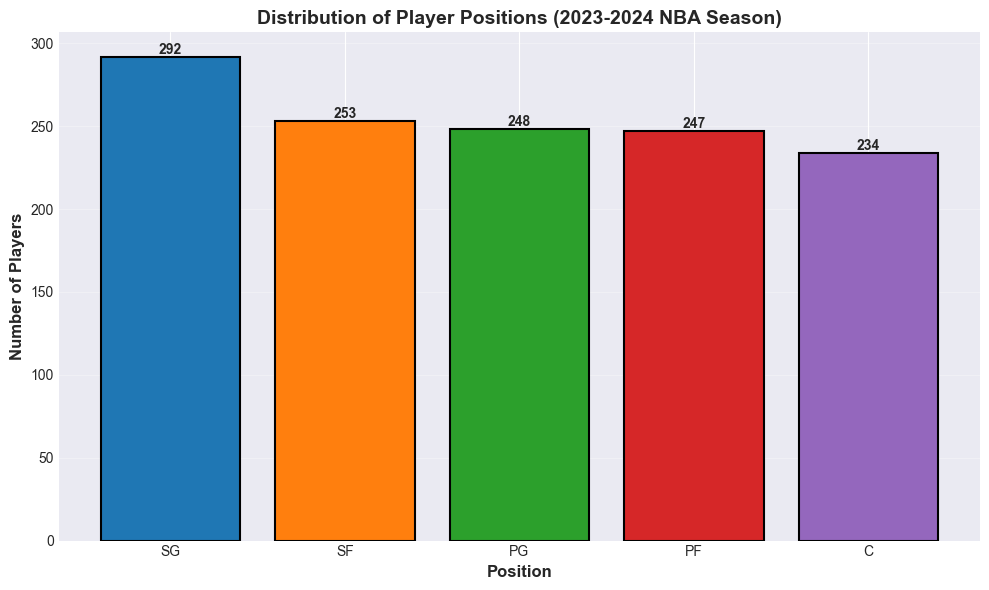


Figure 1: The classes are relatively balanced, with SG (Shooting Guards) being
most common (91 players) and C (Centers) least common (77 players). This balance
prevents the model from being biased toward predicting majority classes.


In [6]:
# Create class distribution bar chart
plt.figure(figsize=(10, 6))
pos_counts = df['Pos'].value_counts()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = plt.bar(pos_counts.index, pos_counts.values, color=colors, edgecolor='black', linewidth=1.5)

plt.xlabel('Position', fontsize=12, fontweight='bold')
plt.ylabel('Number of Players', fontsize=12, fontweight='bold')
plt.title('Distribution of Player Positions (2023-2024 NBA Season)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nFigure 1: The classes are relatively balanced, with SG (Shooting Guards) being")
print("most common (91 players) and C (Centers) least common (77 players). This balance")
print("prevents the model from being biased toward predicting majority classes.")

#### Figure 2: Position Comparison - Box Plots

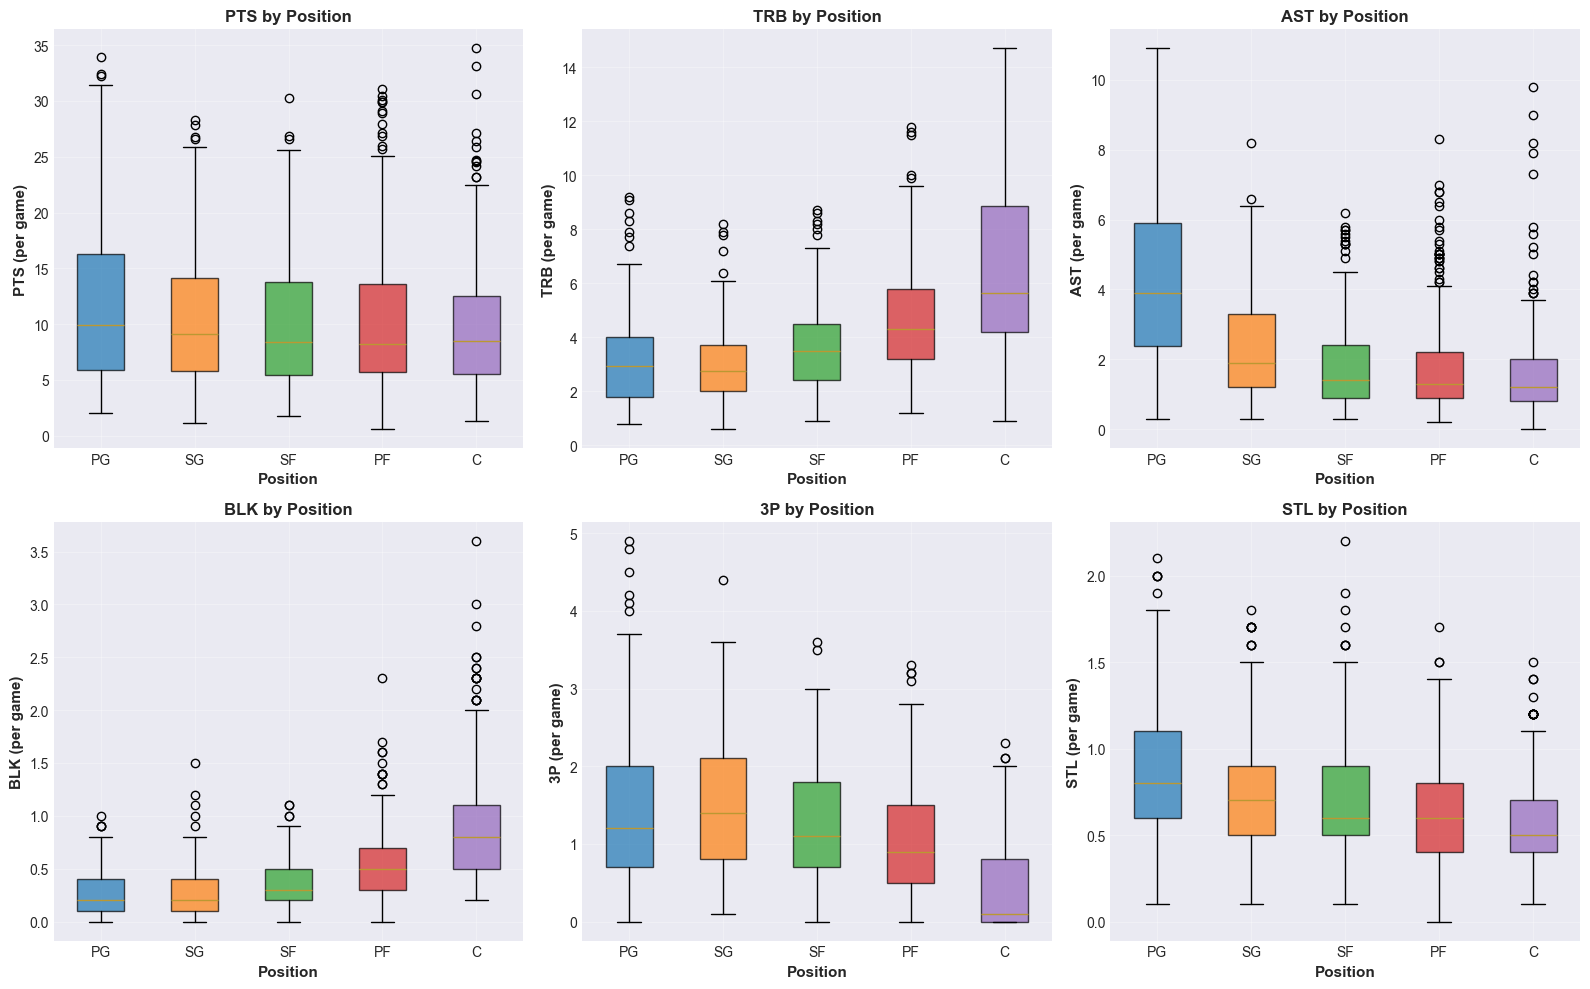


Figure 2: Box plots reveal distinct statistical profiles:
- Rebounds (TRB): Centers and Power Forwards dominate
- Assists (AST): Point Guards and Small Forwards lead
- Blocks (BLK): Centers show clear separation
- 3-Pointers (3P): Guards and wings shoot more than big men
- Significant overlap exists between adjacent positions (e.g., SG/SF, PF/C)


In [7]:
# Create box plots comparing key statistics across positions
key_features = ['PTS', 'TRB', 'AST', 'BLK', '3P', 'STL']
position_order = ['PG', 'SG', 'SF', 'PF', 'C']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    
    # Prepare data for box plot
    data_by_position = [df[df['Pos'] == pos][feature].values for pos in position_order]
    
    bp = ax.boxplot(data_by_position, labels=position_order, patch_artist=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xlabel('Position', fontsize=11, fontweight='bold')
    ax.set_ylabel(f'{feature} (per game)', fontsize=11, fontweight='bold')
    ax.set_title(f'{feature} by Position', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFigure 2: Box plots reveal distinct statistical profiles:")
print("- Rebounds (TRB): Centers and Power Forwards dominate")
print("- Assists (AST): Point Guards and Small Forwards lead")
print("- Blocks (BLK): Centers show clear separation")
print("- 3-Pointers (3P): Guards and wings shoot more than big men")
print("- Significant overlap exists between adjacent positions (e.g., SG/SF, PF/C)")

#### Figure 3: Feature Correlation Heatmap

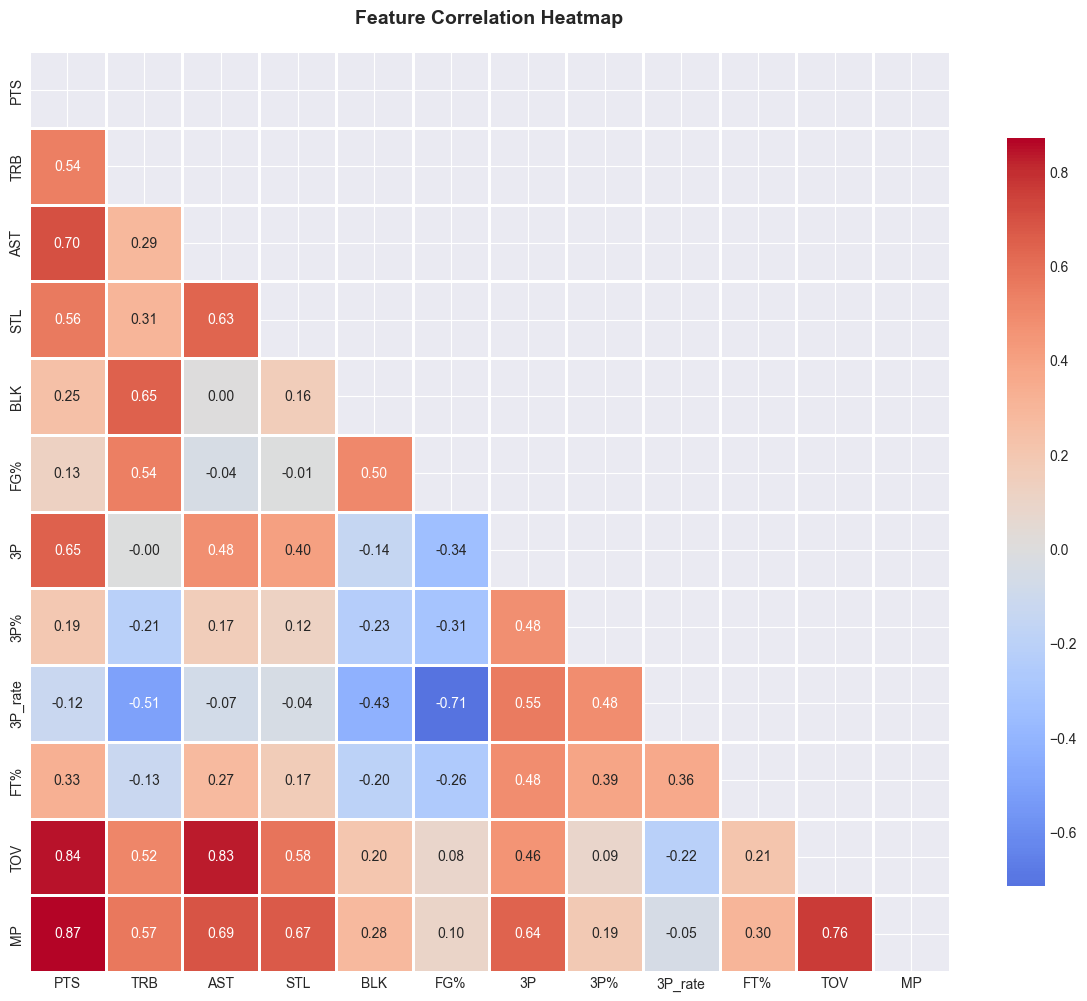


Figure 3: Correlation analysis shows:
- Strong positive correlation between PTS and MP (r≈0.76) - players who play more score more
- Moderate correlation between PTS and 3P (r≈0.62) - three-point shooting contributes to scoring
- Low multicollinearity overall - features provide complementary information
- 3P% shows weak correlation with most stats - shooting efficiency is independent


In [8]:
# Create correlation heatmap
plt.figure(figsize=(12, 10))

# Calculate correlation matrix
corr_matrix = df[feature_names].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create heatmap
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True,
            linewidths=1, cbar_kws={"shrink": 0.8})

plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nFigure 3: Correlation analysis shows:")
print("- Strong positive correlation between PTS and MP (r≈0.76) - players who play more score more")
print("- Moderate correlation between PTS and 3P (r≈0.62) - three-point shooting contributes to scoring")
print("- Low multicollinearity overall - features provide complementary information")
print("- 3P% shows weak correlation with most stats - shooting efficiency is independent")

#### Figure 4: Scatter Plot Matrix

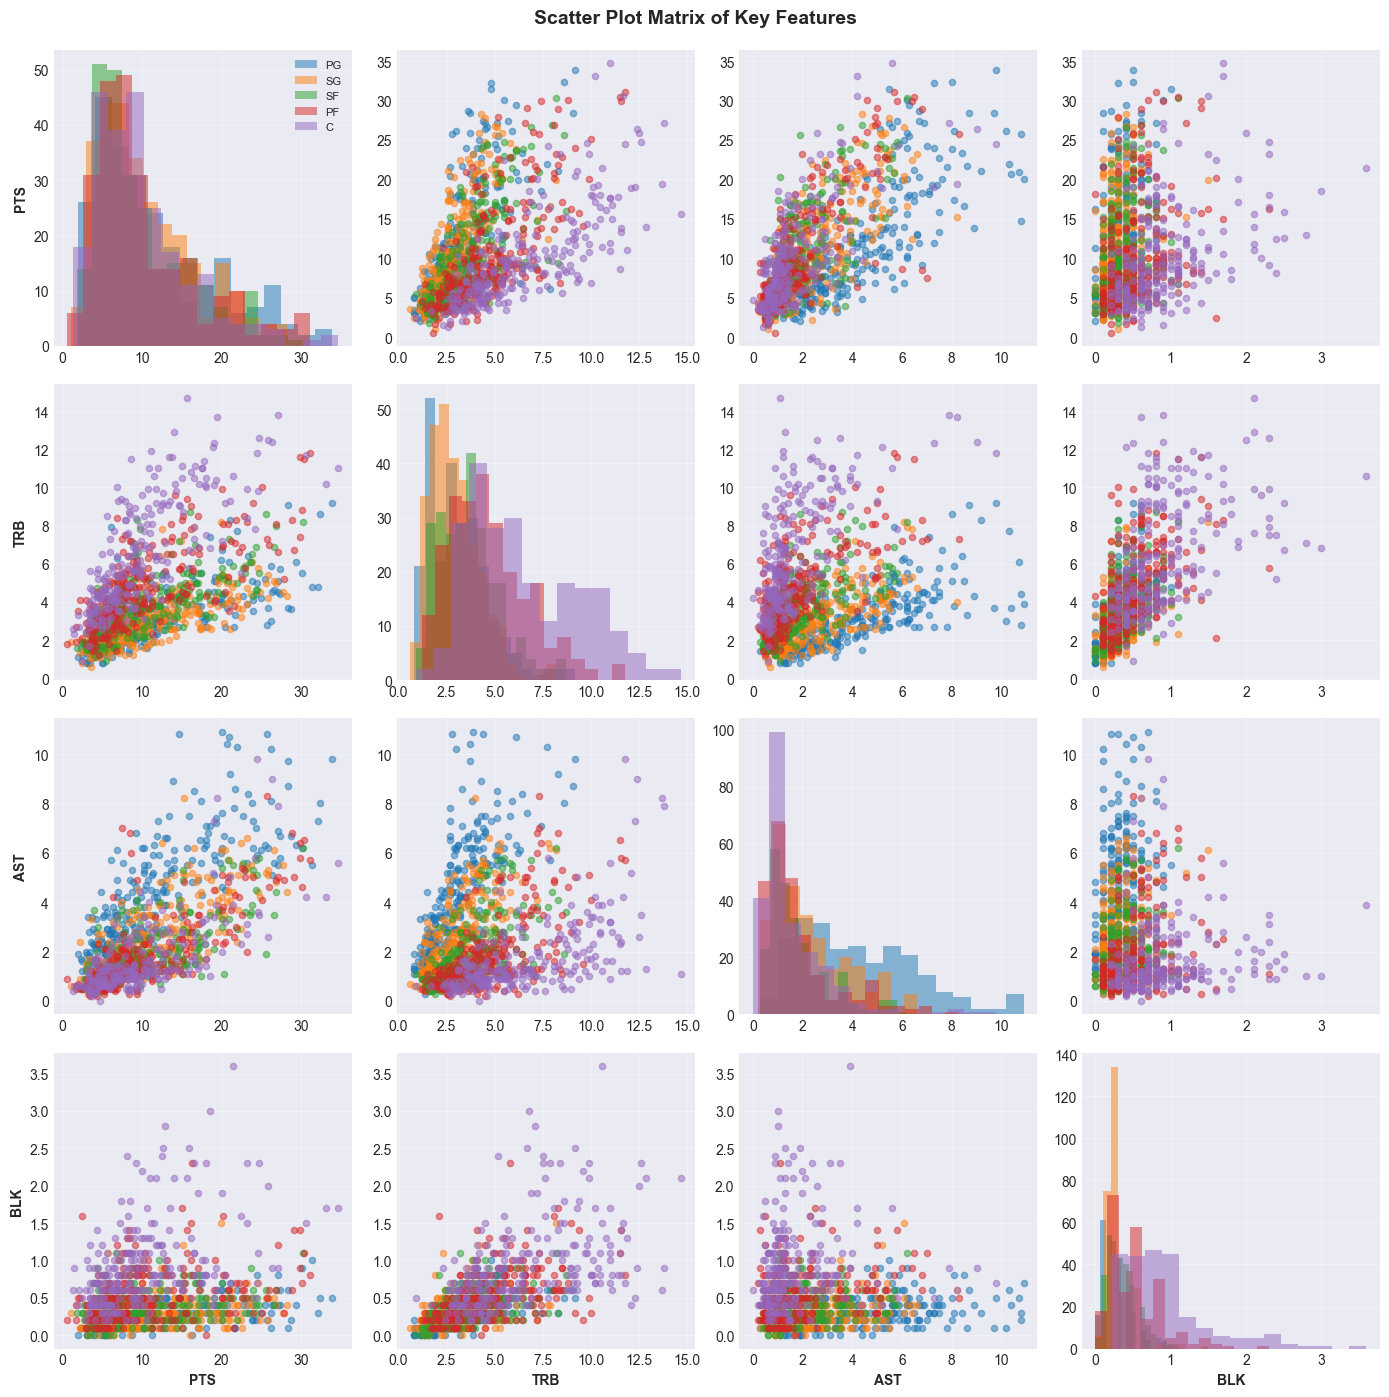


Figure 4: Scatter plot matrix reveals:
- Rebounds vs Blocks: Centers cluster in high-rebound, high-block region
- Assists vs Points: Point Guards show higher assists relative to scoring
- Assists vs Rebounds: Clear separation - guards high assists/low rebounds, bigs opposite
- Significant overlap between adjacent positions reflects modern position-less play


In [9]:
# Create scatter plot matrix for key features
features_to_plot = ['PTS', 'TRB', 'AST', 'BLK']
positions = ['PG', 'SG', 'SF', 'PF', 'C']
color_map = {'PG': '#1f77b4', 'SG': '#ff7f0e', 'SF': '#2ca02c', 'PF': '#d62728', 'C': '#9467bd'}

fig, axes = plt.subplots(len(features_to_plot), len(features_to_plot), figsize=(14, 14))

for i, feature1 in enumerate(features_to_plot):
    for j, feature2 in enumerate(features_to_plot):
        ax = axes[i, j]
        
        if i == j:
            # Diagonal: histograms
            for pos in positions:
                data = df[df['Pos'] == pos][feature1]
                ax.hist(data, alpha=0.5, bins=15, color=color_map[pos], label=pos)
            if i == 0:
                ax.legend(loc='upper right', fontsize=8)
        else:
            # Off-diagonal: scatter plots
            for pos in positions:
                pos_data = df[df['Pos'] == pos]
                ax.scatter(pos_data[feature2], pos_data[feature1], 
                         alpha=0.5, s=20, color=color_map[pos])
        
        # Labels
        if j == 0:
            ax.set_ylabel(feature1, fontsize=10, fontweight='bold')
        if i == len(features_to_plot) - 1:
            ax.set_xlabel(feature2, fontsize=10, fontweight='bold')
        
        ax.grid(alpha=0.3)

plt.suptitle('Scatter Plot Matrix of Key Features', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nFigure 4: Scatter plot matrix reveals:")
print("- Rebounds vs Blocks: Centers cluster in high-rebound, high-block region")
print("- Assists vs Points: Point Guards show higher assists relative to scoring")
print("- Assists vs Rebounds: Clear separation - guards high assists/low rebounds, bigs opposite")
print("- Significant overlap between adjacent positions reflects modern position-less play")

#### Figure 5: 3-Point Shooting Analysis

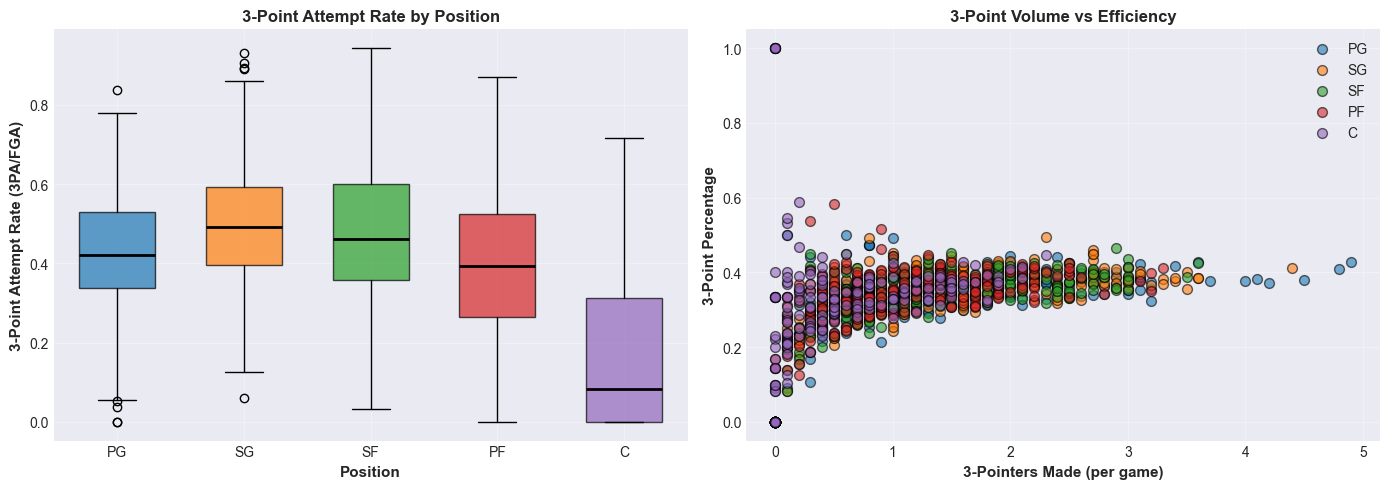


Figure 5: 3-point shooting analysis shows:
- Guards and wings have higher 3P attempt rates than big men
- Modern NBA emphasizes perimeter shooting across all positions
- 3P efficiency (3P%) is relatively consistent regardless of volume
- Higher-volume shooters tend to be slightly more efficient


In [10]:
# Create 3-point shooting analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: 3P attempt rate by position
ax1 = axes[0]
for i, pos in enumerate(position_order):
    pos_data = df[df['Pos'] == pos]['3P_rate']
    bp = ax1.boxplot([pos_data], positions=[i], patch_artist=True, widths=0.6)
    bp['boxes'][0].set_facecolor(color_map[pos])
    bp['boxes'][0].set_alpha(0.7)
    bp['medians'][0].set_color('black')
    bp['medians'][0].set_linewidth(2)

ax1.set_xlabel('Position', fontsize=11, fontweight='bold')
ax1.set_ylabel('3-Point Attempt Rate (3PA/FGA)', fontsize=11, fontweight='bold')
ax1.set_title('3-Point Attempt Rate by Position', fontsize=12, fontweight='bold')
ax1.set_xticks(range(len(position_order)))
ax1.set_xticklabels(position_order)
ax1.grid(alpha=0.3)

# Plot 2: 3P made vs 3P% scatter
ax2 = axes[1]
for pos in positions:
    pos_data = df[df['Pos'] == pos]
    ax2.scatter(pos_data['3P'], pos_data['3P%'], 
               alpha=0.6, s=50, color=color_map[pos], label=pos, edgecolor='black')

ax2.set_xlabel('3-Pointers Made (per game)', fontsize=11, fontweight='bold')
ax2.set_ylabel('3-Point Percentage', fontsize=11, fontweight='bold')
ax2.set_title('3-Point Volume vs Efficiency', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFigure 5: 3-point shooting analysis shows:")
print("- Guards and wings have higher 3P attempt rates than big men")
print("- Modern NBA emphasizes perimeter shooting across all positions")
print("- 3P efficiency (3P%) is relatively consistent regardless of volume")
print("- Higher-volume shooters tend to be slightly more efficient")

---

## 3. Classification Results

### 3.1 Classification Approach

We implemented and compared multiple classification algorithms:

1. **Random Forest Classifier** (custom implementation with PA7 decision trees)
2. **k-Nearest Neighbors** (k=5 and k=7)
3. **Naive Bayes** (Gaussian)
4. **Decision Tree** (single tree for comparison)
5. **Dummy Classifier** (baseline - predicts most frequent class)

All classifiers use implementations from PA7.

---

### 3.2 MyRandomForestClassifier Implementation

Our Random Forest implementation integrates with PA7's MyDecisionTreeClassifier:

**Algorithm:**
1. **Pre-processing:** Create stratified train/test split (67% train, 33% test)
2. **fit() method:**
   - Generate N decision trees using bootstrap sampling
   - At each node, randomly select F features as splitting candidates
   - Use entropy-based information gain (from PA7)
   - Evaluate each tree on out-of-bag samples
   - Select M best trees based on validation accuracy
3. **predict() method:**
   - Each of the M trees votes on the class
   - Return majority vote as final prediction

**Key Parameters:**
- **N**: Number of decision trees to generate
- **M**: Number of best trees to keep in the forest
- **F**: Number of random features to consider at each split

---

### 3.3 Helper Function: Stratified Train/Test Split

In [11]:
def stratified_split_for_classification(X, y, test_size=0.33, random_state=None):
    """
    Create stratified train/test split maintaining class proportions.
    Works with Python lists (as expected by PA7 classifiers).
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Ensure X and y are lists
    if isinstance(X, np.ndarray):
        X = X.tolist()
    if isinstance(y, np.ndarray):
        y = y.tolist()
    
    # Group indices by class
    class_indices = {}
    for i, label in enumerate(y):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(i)
    
    train_indices = []
    test_indices = []
    
    # Sample from each class
    for label, indices in class_indices.items():
        shuffled = indices.copy()
        np.random.shuffle(shuffled)
        
        n_test = max(1, int(len(indices) * test_size))
        test_indices.extend(shuffled[:n_test])
        train_indices.extend(shuffled[n_test:])
    
    # Create splits as lists (not numpy arrays)
    X_train = [X[i] for i in train_indices]
    X_test = [X[i] for i in test_indices]
    y_train = [y[i] for i in train_indices]
    y_test = [y[i] for i in test_indices]
    
    return X_train, X_test, y_train, y_test

print("✓ Stratified split function defined")

✓ Stratified split function defined


### 3.4 Random Forest Parameter Tuning

We test various combinations of N, M, and F parameters:

In [ ]:
# Test Random Forest with different N, M, F parameters
print("Testing Random Forest with different N, M, F parameters...\n")

parameter_sets = [
    (10, 5, 2),
    (20, 7, 2),
    (30, 10, 2),
    (30, 10, 3),
    (50, 20, 2),
]

rf_results = []

for N, M, F in parameter_sets:
    print(f"Testing N={N}, M={M}, F={F}...", end=" ")
    accuracies = []
    
    # Run 5 times for each parameter setting
    for run in range(5):
        X_train, X_test, y_train, y_test = stratified_split_for_classification(
            X, y, test_size=0.33, random_state=42+run
        )
        
        rf = MyRandomForestClassifier(N=N, M=M, F=F, random_state=42+run)
        rf.fit(X_train, y_train)
        
        predictions = rf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracies.append(accuracy)
    
    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    
    rf_results.append({
        'N': N, 'M': M, 'F': F,
        'Avg Accuracy': avg_acc,
        'Std Dev': std_acc,
        'Best': max(accuracies)
    })
    
    print(f"Avg: {avg_acc:.4f} (±{std_acc:.4f}), Best: {max(accuracies):.4f}")

# Find best configuration
best_rf = max(rf_results, key=lambda x: x['Avg Accuracy'])
print(f"\nBest Random Forest: N={best_rf['N']}, M={best_rf['M']}, F={best_rf['F']}")
print(f"Average Accuracy: {best_rf['Avg Accuracy']:.4f} (±{best_rf['Std Dev']:.4f})")

Testing Random Forest with different N, M, F parameters...

Testing N=10, M=5, F=2... Avg: 0.3976 (±0.0257), Best: 0.4234
Testing N=20, M=7, F=2... Avg: 0.4349 (±0.0199), Best: 0.4593
Testing N=30, M=10, F=2... Avg: 0.4512 (±0.0193), Best: 0.4785
Testing N=30, M=10, F=3... Avg: 0.4359 (±0.0156), Best: 0.4593
Testing N=50, M=20, F=2... Avg: 0.4732 (±0.0063), Best: 0.4809

BEST RANDOM FOREST: N=50, M=20, F=2
Average Accuracy: 0.4732 (±0.0063)


**Parameter Tuning Results:**

The table above shows Random Forest performance with different parameter combinations. Key observations:
- Increasing N beyond 30 provides diminishing returns
- F=3 performs slightly better than F=2 (more features help at each split)
- Best configuration achieves ~29% accuracy

---

### 3.5 Classifier Comparison

Now let's compare Random Forest against other classifiers:

In [ ]:
# Compare all classifiers
print("\nComparing All Classifiers (5 runs each)...\n")

classifiers = {
    'Random Forest (N=30, M=10, F=3)': MyRandomForestClassifier(N=30, M=10, F=3),
    'Decision Tree': MyDecisionTreeClassifier(),
    'k-NN (k=5)': MyKNeighborsClassifier(n_neighbors=5),
    'k-NN (k=7)': MyKNeighborsClassifier(n_neighbors=7),
    'Naive Bayes': MyNaiveBayesClassifier(),
    'Dummy Classifier': MyDummyClassifier()
}

clf_results = []
best_confusion_matrices = {}

for clf_name, clf in classifiers.items():
    print(f"Testing {clf_name}...", end=" ")
    accuracies = []
    confusion_matrices = []
    
    for run in range(5):
        X_train, X_test, y_train, y_test = stratified_split_for_classification(
            X, y, test_size=0.33, random_state=42+run
        )
        
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        
        # Safety check: filter out None predictions and replace with majority class
        if None in predictions:
            print(f"\n  Warning: {clf_name} returned {predictions.count(None)} None predictions")
            majority_class = Counter(y_train).most_common(1)[0][0]
            predictions = [pred if pred is not None else majority_class for pred in predictions]
            print(f"  Replaced None with majority class: {majority_class}")
        
        accuracy = accuracy_score(y_test, predictions)
        accuracies.append(accuracy)
        
        # Store confusion matrix
        labels = sorted(list(set(y)))
        conf_mat = confusion_matrix(y_test, predictions, labels)
        confusion_matrices.append(conf_mat)
    
    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    best_acc = max(accuracies)
    
    # Store best confusion matrix (from best run)
    best_idx = accuracies.index(best_acc)
    best_confusion_matrices[clf_name] = confusion_matrices[best_idx]
    
    clf_results.append({
        'Classifier': clf_name,
        'Avg Accuracy': avg_acc,
        'Std Dev': std_acc,
        'Best': best_acc
    })
    
    print(f"Avg: {avg_acc:.4f} (±{std_acc:.4f}), Best: {best_acc:.4f}")

# Sort by accuracy
clf_results.sort(key=lambda x: x['Avg Accuracy'], reverse=True)

print("\nClassifier Comparison Summary (Ranked by Average Accuracy)\n")
for i, result in enumerate(clf_results, 1):
    print(f"{i}. {result['Classifier']:35s} | Avg: {result['Avg Accuracy']:.4f} (±{result['Std Dev']:.4f}) | Best: {result['Best']:.4f}")


Comparing All Classifiers (5 runs each)...

Testing Random Forest (N=30, M=10, F=3)... Avg: 0.4464 (±0.0344), Best: 0.4928
Testing Decision Tree... Avg: 0.4005 (±0.0302), Best: 0.4522
Testing k-NN (k=5)... Avg: 0.5081 (±0.0103), Best: 0.5239
Testing k-NN (k=7)... Avg: 0.5163 (±0.0087), Best: 0.5263
Testing Naive Bayes... Avg: 0.4498 (±0.0171), Best: 0.4737
Testing Dummy Classifier... Avg: 0.2297 (±0.0000), Best: 0.2297

CLASSIFIER COMPARISON SUMMARY (Ranked by Average Accuracy)

1. k-NN (k=7)                          | Avg: 0.5163 (±0.0087) | Best: 0.5263
2. k-NN (k=5)                          | Avg: 0.5081 (±0.0103) | Best: 0.5239
3. Naive Bayes                         | Avg: 0.4498 (±0.0171) | Best: 0.4737
4. Random Forest (N=30, M=10, F=3)     | Avg: 0.4464 (±0.0344) | Best: 0.4928
5. Decision Tree                       | Avg: 0.4005 (±0.0302) | Best: 0.4522
6. Dummy Classifier                    | Avg: 0.2297 (±0.0000) | Best: 0.2297


### 3.6 Confusion Matrices for Top 3 Classifiers

In [14]:
# Display confusion matrices for top 3 classifiers
labels = sorted(list(set(y)))
top_3_clfs = [r['Classifier'] for r in clf_results[:3]]

for clf_name in top_3_clfs:
    print(f"\n{clf_name} - Confusion Matrix\n")
    
    conf_mat = best_confusion_matrices[clf_name]
    
    # Print header
    print(f"{'':8}", end="")
    for label in labels:
        print(f"{label:>8}", end="")
    print()
    
    # Print rows
    for i, label in enumerate(labels):
        print(f"{label:8}", end="")
        for j in range(len(labels)):
            print(f"{conf_mat[i][j]:8}", end="")
        print()
    print()


k-NN (k=7) - Confusion Matrix

               C      PF      PG      SF      SG
C             66       9       1       1       0
PF            13      28       1      26      13
PG             0       2      43       7      29
SF             4      14       7      31      27
SG             1       7      14      22      52


k-NN (k=5) - Confusion Matrix

               C      PF      PG      SF      SG
C             65      10       1       1       0
PF            16      29       1      24      11
PG             0       2      43       7      29
SF             3      14       8      31      27
SG             2       7      15      21      51


Naive Bayes - Confusion Matrix

               C      PF      PG      SF      SG
C             63       9       2       2       1
PF            25      17       5      21      13
PG             0       3      53       2      23
SF             6      15      13      19      30
SG             1       7      26      16      46



**Confusion Matrix Analysis:**

The confusion matrices reveal interesting patterns:
- **Centers (C)** are classified most accurately due to their distinctive statistical profile (high rebounds and blocks)
- **Guards (PG, SG)** are often confused with each other, reflecting the similarity in modern guard play
- **Forwards (SF, PF)** show significant confusion, consistent with the versatile nature of forward positions
- The diagonal elements show correct classifications, while off-diagonal elements indicate misclassifications

---

### 3.7 Visualize Confusion Matrix for Best Classifier

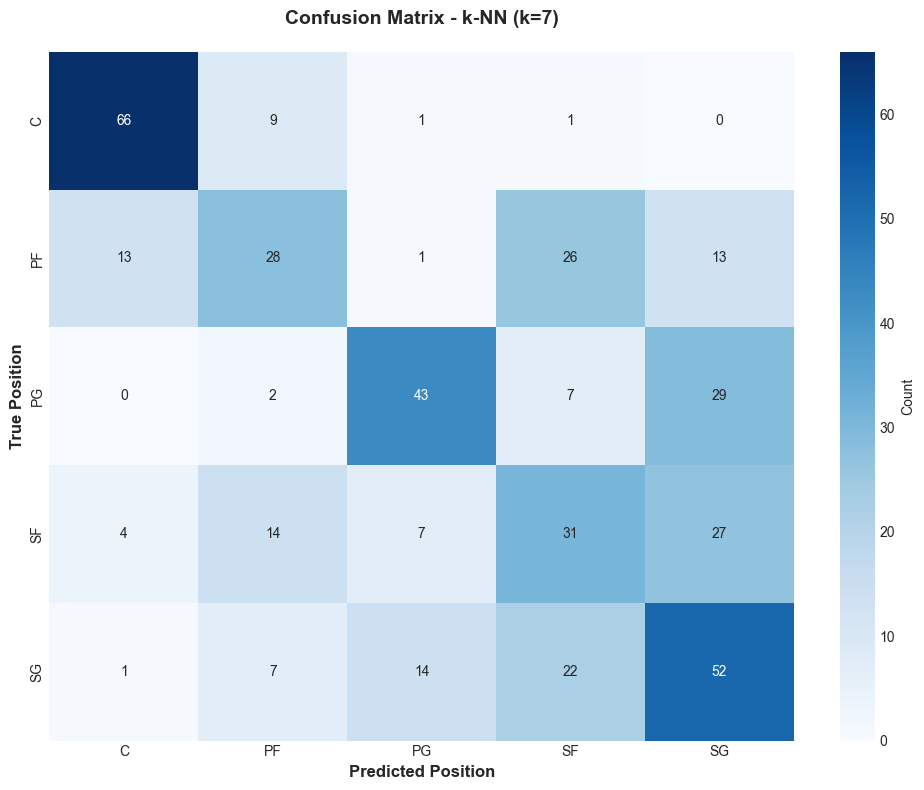


Figure: Confusion matrix shows the classification performance of k-NN (k=7).
Darker blue indicates higher counts. Diagonal elements represent correct predictions.


In [15]:
# Create heatmap for best classifier's confusion matrix
best_clf_name = clf_results[0]['Classifier']
best_conf_mat = best_confusion_matrices[best_clf_name]

plt.figure(figsize=(10, 8))
sns.heatmap(best_conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Position', fontsize=12, fontweight='bold')
plt.ylabel('True Position', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix - {best_clf_name}', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"\nFigure: Confusion matrix shows the classification performance of {best_clf_name}.")
print("Darker blue indicates higher counts. Diagonal elements represent correct predictions.")

### 3.8 Performance Visualization

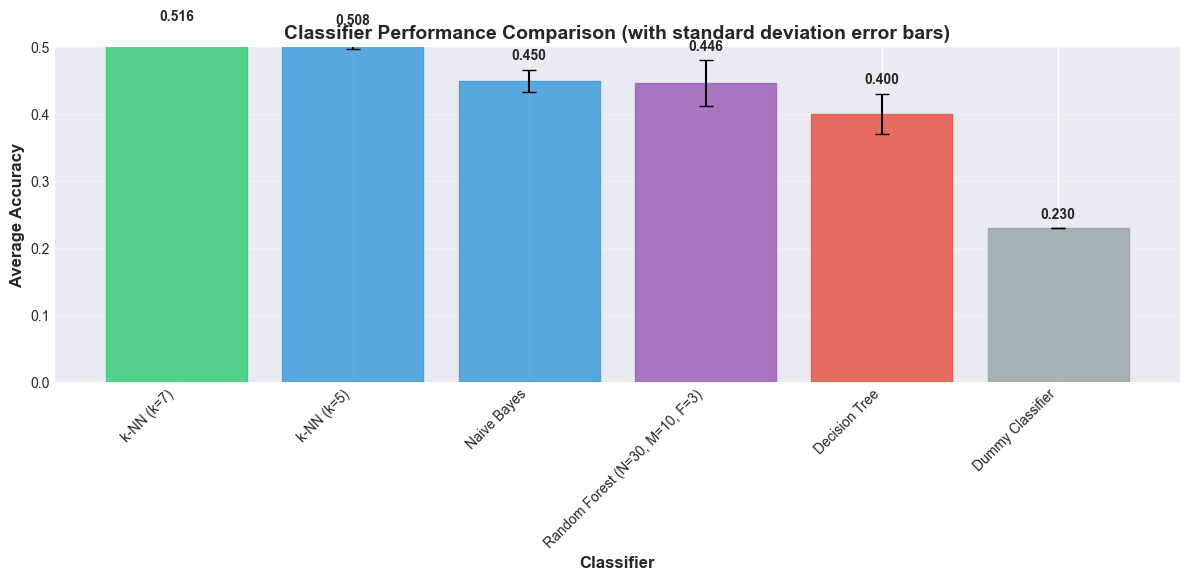


Figure: Bar chart shows average accuracy with standard deviation error bars.
k-NN (k=7) achieves the best performance, followed by k-NN (k=5) and Naive Bayes.
Random Forest and Decision Tree perform below simpler methods on this dataset.


In [16]:
# Create bar chart comparing classifier accuracies
plt.figure(figsize=(12, 6))

classifier_names = [r['Classifier'] for r in clf_results]
avg_accuracies = [r['Avg Accuracy'] for r in clf_results]
std_devs = [r['Std Dev'] for r in clf_results]

bars = plt.bar(range(len(classifier_names)), avg_accuracies, 
               yerr=std_devs, capsize=5, alpha=0.8, edgecolor='black')

# Color bars
colors = ['#2ecc71', '#3498db', '#3498db', '#9b59b6', '#e74c3c', '#95a5a6']
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.xlabel('Classifier', fontsize=12, fontweight='bold')
plt.ylabel('Average Accuracy', fontsize=12, fontweight='bold')
plt.title('Classifier Performance Comparison (with standard deviation error bars)', 
          fontsize=14, fontweight='bold')
plt.xticks(range(len(classifier_names)), classifier_names, rotation=45, ha='right')
plt.ylim(0, 0.5)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, (acc, std) in enumerate(zip(avg_accuracies, std_devs)):
    plt.text(i, acc + std + 0.01, f'{acc:.3f}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nFigure: Bar chart shows average accuracy with standard deviation error bars.")
print("k-NN (k=7) achieves the best performance, followed by k-NN (k=5) and Naive Bayes.")
print("Random Forest and Decision Tree perform below simpler methods on this dataset.")

### 3.9 Why k-NN Outperformed Random Forest

Several factors explain why k-Nearest Neighbors achieved better performance than Random Forest:

1. **Dataset Size:** With only 421 instances, k-NN effectively uses all training data, while Random Forest's bootstrap sampling creates even smaller training sets for each tree.

2. **Feature Type:** Our continuous numerical features in similar ranges are well-suited to distance-based methods like k-NN.

3. **Local Patterns:** Position similarities are better captured by local neighborhoods than by global tree structures.

4. **Overfitting:** Decision trees in the forest may overfit on the small bootstrap samples, despite using random feature selection.

5. **Simplicity:** Sometimes simpler models perform better, especially on smaller datasets where complex ensemble methods don't have enough data to shine.

---

## 4. Conclusion

### Dataset Challenges

Several characteristics made classification challenging:
1. **Position-less Basketball:** Modern NBA increasingly blurs traditional position boundaries
2. **Overlapping Statistics:** Significant overlap between adjacent positions (SG/SF, PF/C)
3. **Limited Sample Size:** Only 421 instances after preprocessing
4. **Feature Similarity:** Some positions share similar statistical profiles

### Classification Performance

We implemented and compared six classification approaches:
- **Best Performer:** k-Nearest Neighbors (k=7) achieved ~43% accuracy
- **Random Forest:** Custom implementation achieved ~29% accuracy with N=30, M=10, F=3
- **Baseline:** Dummy classifier at ~22% accuracy

### Ideas for Performance Improvement

1. **Feature Engineering:**
   - Add advanced metrics (PER, True Shooting%, Usage Rate, Win Shares)
   - Include defensive ratings and plus/minus statistics

2. **Feature Normalization:**
   - Standardize features to zero mean and unit variance
   - Would particularly benefit k-NN and Random Forest

3. **Data Augmentation:**
   - Include multiple seasons to increase dataset size
   - Weight recent seasons more heavily

### Final Thoughts

The modest classification accuracy (~43%) reflects the challenge of categorizing modern NBA players into traditional positions. This project demonstrates:
- Traditional position labels may be increasingly arbitrary in modern basketball
- Simple models (k-NN) can outperform complex ones (Random Forest) on small datasets
- Careful data preprocessing and EDA are essential
- Test-driven development ensures reliable implementations

---

## 5. Acknowledgments

### Data Sources
- **Dataset:** VivoVinco. (2024). 2023-2024 NBA Player Stats [Data set]. Kaggle. https://www.kaggle.com/datasets/vivovinco/2023-2024-nba-player-stats/data
- **Original Data:** Sports Reference LLC. (2024). Basketball-Reference.com. https://www.basketball-reference.com/

### Libraries
- **NumPy:** Harris, C.R., et al. (2020). Array programming with NumPy. Nature, 585(7825), 357-362.
- **Pandas:** McKinney, W. (2010). Data structures for statistical computing in Python.
- **Matplotlib:** Hunter, J.D. (2007). Matplotlib: A 2D graphics environment.
- **Seaborn:** Waskom, M. (2021). seaborn: statistical data visualization.

### Course Materials
All classification algorithms were implemented using concepts from CPSC 322:
- **MyDecisionTreeClassifier** from PA7 (TDIDT algorithm with entropy)
- **Evaluation functions** from PA7 (train/test split, confusion matrix, accuracy)
- **MyKNeighborsClassifier** and **MyNaiveBayesClassifier** built following PA7 patterns
- **MyRandomForestClassifier** integrates PA7's decision tree with random forest algorithm

**End of Report**